# Data acquisition/processing and full wave inversion demo using SPECFEM3D_GLOBE

In [1]:
# import necessary modules

%matplotlib inline
from obspy.clients.fdsn.mass_downloader import GlobalDomain
from obspy.clients.fdsn.mass_downloader import MassDownloader
from obspy.clients.fdsn.mass_downloader import Restrictions
from obspy.geodetics import locations2degrees
from obspy.signal.invsim import cosine_sac_taper
from obspy.signal.util import _npts2nfft
from obspy.imaging.beachball import beachball, beach

import obspy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

import os

disp_unit = 'mm'

## Downloading Event Information and 1D/3D synthetic data

In this example, we use Global Centroid Moment Tensor (CMT) solution for the 2024 Noto Peninsula earthquake, which can be downloaded from [The Harvard Centroid Moment Tenosr Catalog Web Page](https://www.globalcmt.org/CMTsearch.html).  

We can also download the 1D/3D synthetic data for this event from the [Global Shake Movie of Princeton University](https://global.shakemovie.princeton.edu/event.jsp?evid=C202401010710A&mode=scientific)

/home/ubuntu/workspace/miniconda3/envs/scoped_workshop/lib/python3.11/site-packages/obspy/imaging/beachball.py:186: UserWarning: There is a known bug when plotting semi-transparent patches for non-DC sources, which leads to blending of pressure and tension color, see issue #1464.
  warnings.warn(msg)


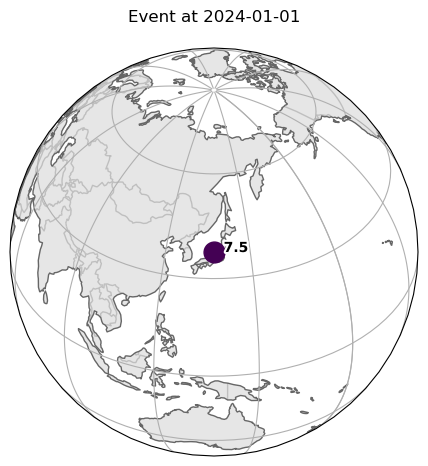

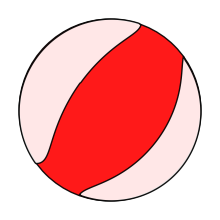

In [2]:
# event name
eqname = "C202401010710A"
# file path to the downloaded event
quakeml_filename = "CMTs/{}".format(eqname)
# read the event
cat = obspy.read_events(quakeml_filename)
# plot the event position
cat.plot(projection="ortho", show=False)

# plot focal mechanism
_mt = cat[0].focal_mechanisms[0].moment_tensor.tensor
mt = [_mt.m_rr, _mt.m_tt, _mt.m_pp, _mt.m_rt, _mt.m_rp, _mt.m_tp]
beachball(mt, facecolor='red', edgecolor='black', linewidth=1, alpha=0.9, size=200)

pass

### Finite fault model

The finite fault model for the 2024 Noto Peninsula earthquake is available from the [USGS Earthquake Hazards Progam](https://earthquake.usgs.gov/earthquakes/eventpage/us6000m0xl/finite-fault)


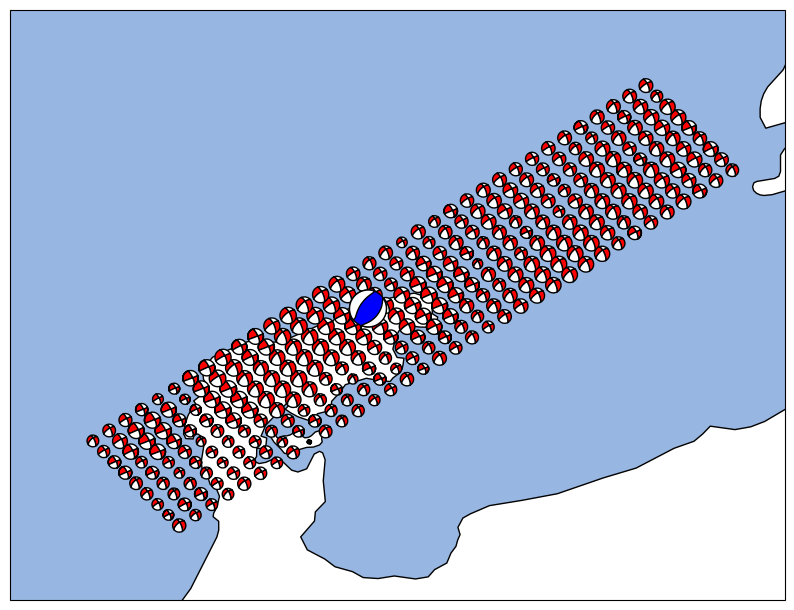

In [3]:
# read and plot CMTSOLUTIONS

fname = "finite_fault/CMTSOLUTION"
dummy_header = " PDEQ2024  1  1  7 10  9.70  37.5000  137.2400  10.0 0.0 7.5 NEAR WEST COAST OF HONSH"
evs = obspy.Catalog()
with open(fname, "r") as f:
    lines = f.readlines(); lines = lines[1:]
    _tmp_str= ""
    for line in lines:
        if not line.startswith("{"):
            if not "centroid_depth" in line:
                _tmp_str += line
        # if the line starts with "{" or the last line of the file, it is the end of the event
        if line.startswith("{") or line == lines[-1]:
            # insert dummy event name
            _tmp_str = f"{dummy_header}\nevent name: cmt_{len(evs)}\n" + _tmp_str
            # write to a temporary file
            with open("tmp.txt", "w") as ftmp:
                ftmp.write(_tmp_str)
            # read the temporary file
            evs += obspy.read_events("tmp.txt", format="CMTSOLUTION")
            _tmp_str = ""

# plot the events with cartopy
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([136.2, 138.3, 36.7, 38.3], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)

for ev in evs:
    # plot mechanism
    _mt = ev.focal_mechanisms[0].moment_tensor.tensor
    xy = [ev.origins[0].longitude, ev.origins[0].latitude]
    mt = [_mt.m_rr, _mt.m_tt, _mt.m_pp, _mt.m_rt, _mt.m_rp, _mt.m_tp]
    # width by magnitude
    width = 0.007 * ev.magnitudes[0].mag
    bb = beach(mt,facecolor='red', linewidth=1, edgecolor='black', xy=xy, width=width, zorder=100)
    # plot the event position
    ax.add_collection(bb)

# plot point source approximation
_mt = cat[0].focal_mechanisms[0].moment_tensor.tensor
mt = [_mt.m_rr, _mt.m_tt, _mt.m_pp, _mt.m_rt, _mt.m_rp, _mt.m_tp]
xy = [cat[0].origins[0].longitude, cat[0].origins[0].latitude]
bb = beach(mt,facecolor='blue', linewidth=1, edgecolor='black', xy=xy, width=0.1, zorder=100)
ax.add_collection(bb)

# erase the temporary file
os.remove("tmp.txt")

pass


## Downloading Observed Seismic Data

We can also download seismic recordings and instrumentation information using obspy.

In [4]:
# download waveform data from IRIS

def download_data(eqname, t0, min_length=180, stations="*"):
    domain = GlobalDomain()

    restrictions = Restrictions(
        # Get data for a whole year.
        starttime=t0,
        endtime=t0+60*min_length,
        # Chunk it to have one file per day.
        chunklength_in_sec=86400,
        # Considering the enormous amount of data associated with continuous
        # requests, you might want to limit the data based on SEED identifiers.
        # If the location code is specified, the location priority list is not
        # used; the same is true for the channel argument and priority list.
        network="*", station=stations, location="00", channel="BH*",
        # The typical use case for such a data set are noise correlations where
        # gaps are dealt with at a later stage.
        reject_channels_with_gaps=True,
        # Same is true with the minimum length. All data might be useful.
        minimum_length=0.0,
        # Guard against the same station having different names.
        minimum_interstation_distance_in_m=100.0)

    # create directories to store the data
    waveform_dir = "data/{}/waveforms".format(eqname)
    stationxml_dir = "data/{}/stations".format(eqname)
    os.makedirs(waveform_dir, exist_ok=True)
    os.makedirs(stationxml_dir, exist_ok=True)

    mdl = MassDownloader(providers=["IRIS"])
    mdl.download(domain, restrictions,
                 mseed_storage=waveform_dir,
                 stationxml_storage=stationxml_dir)



# target station names
stations = "BORK,TARA"

# get the origin time of the event|
event = cat[0]
origin = event.origins[0]

# download data (skipped if already downloaded)
download_data(eqname, origin.time-30, min_length=30, stations=stations)


[2024-05-13 22:50:12,021] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-05-13 22:50:12,387] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2024-05-13 22:50:12,390] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2024-05-13 22:50:12,391] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2024-05-13 22:50:12,500] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.11 seconds)
[2024-05-13 22:50:12,502] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 2 stations (6 channels).
[2024-05-13 22:50:12,504] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 2 stations.
[2024-05-13 22:50:12,505] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 6 time intervals/channels before downloading: EXISTS
[

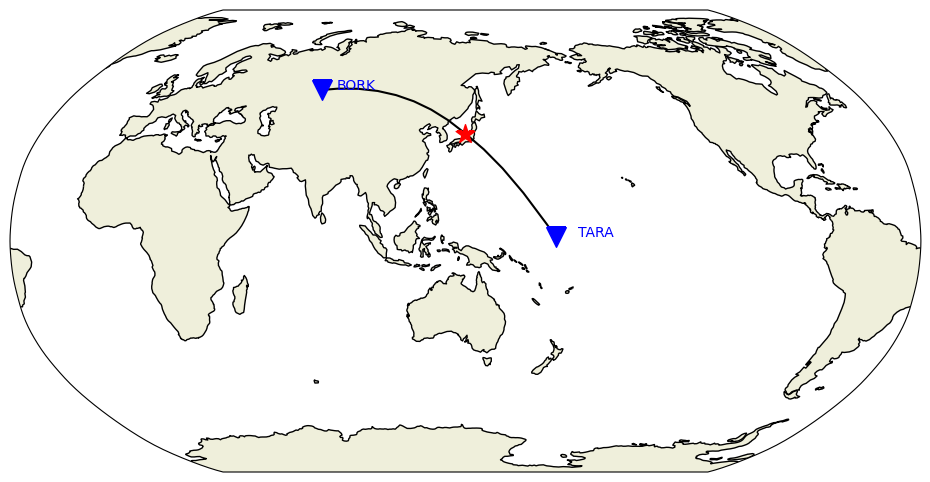

In [5]:
# plot stations on a map

# load the waveform data
obsd_filename_1 = "./data/C202401010710A/waveforms/II.BORK.00.BHZ*.mseed"
obsd_1 = obspy.read(obsd_filename_1)[0]
obsd_filename_2 = "./data/C202401010710A/waveforms/IU.TARA.00.BHZ*.mseed"
obsd_2 = obspy.read(obsd_filename_2)[0]

# load the station information
inv_1 = obspy.read_inventory("./data/C202401010710A/stations/II.BORK.xml")
sta_coord_1 = inv_1.get_coordinates(obsd_1.id)
inv_2 = obspy.read_inventory("./data/C202401010710A/stations/IU.TARA.xml")
sta_coord_2 = inv_2.get_coordinates(obsd_2.id)

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=origin.longitude)))
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax.scatter(origin.longitude, origin.latitude, 200, marker="*", color="red", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_coord_1["longitude"], sta_coord_1["latitude"], 200, marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.text(sta_coord_1["longitude"]*1.1, sta_coord_1["latitude"], "BORK", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_coord_2["longitude"], sta_coord_2["latitude"], 200, marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.text(sta_coord_2["longitude"]*1.05, sta_coord_2["latitude"], "TARA", color="blue", transform=ccrs.PlateCarree(), zorder=100)

ax.plot([origin.longitude, sta_coord_1["longitude"]], [origin.latitude, sta_coord_1["latitude"]], "k", transform=ccrs.Geodetic());
ax.plot([origin.longitude, sta_coord_2["longitude"]], [origin.latitude, sta_coord_2["latitude"]], "k", transform=ccrs.Geodetic());


## Compare downloaded observed and synthetic data

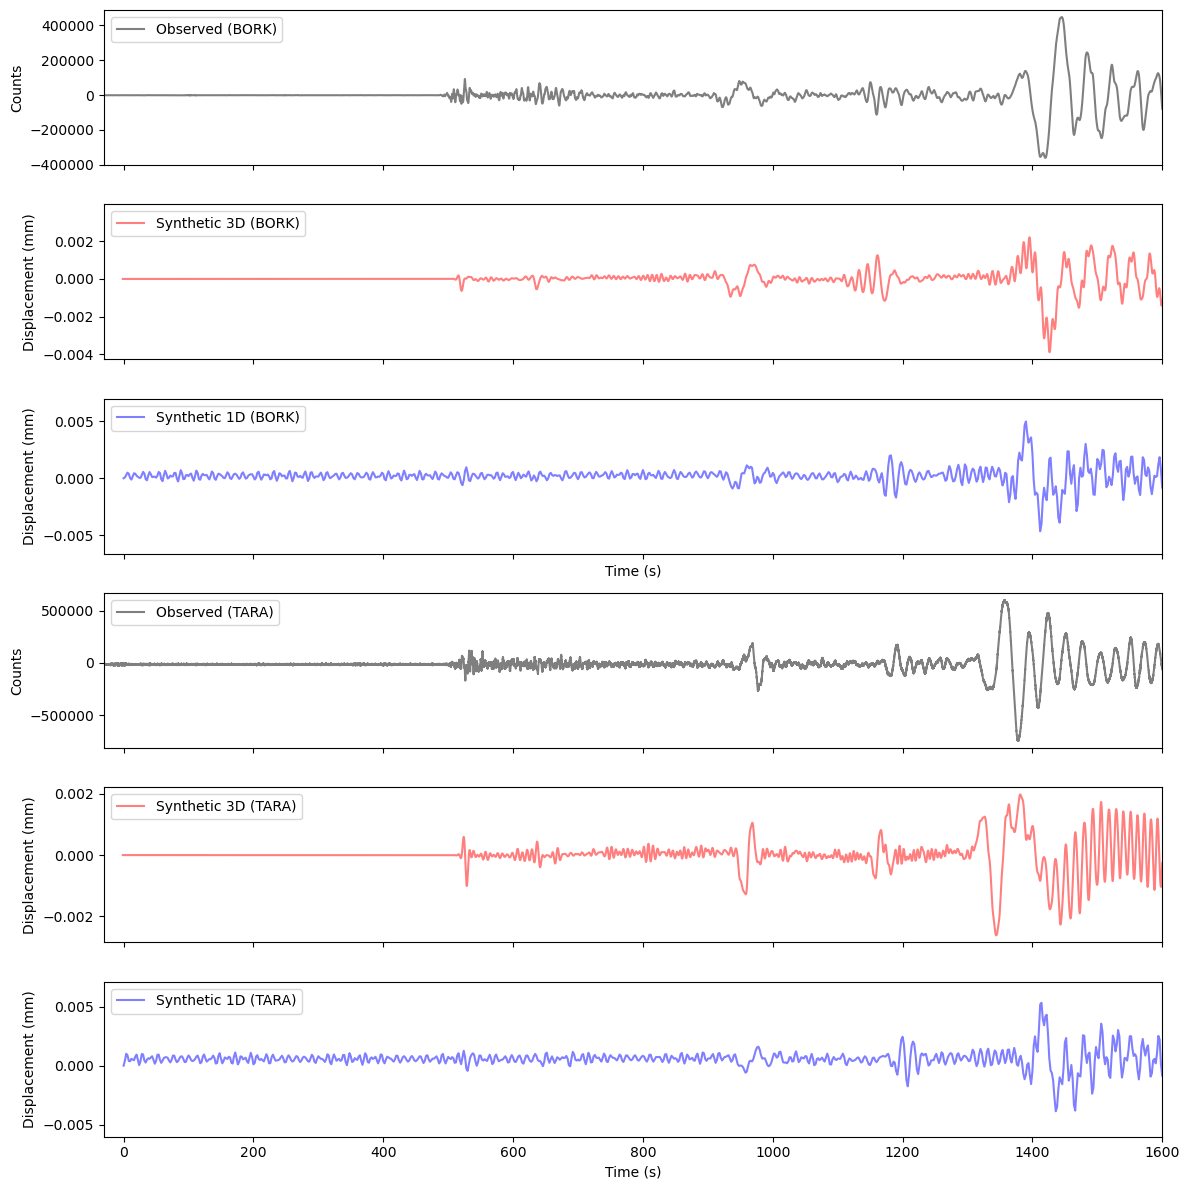

In [6]:
# file path to the downloaded synthetic waveforms
syn1d_fname_bork = "./shakemov_syn/1d/II.BORK.LXZ.modes.sac"
syn3d_fname_bork = "./shakemov_syn/3d/II.BORK.MXZ.sem.sac"
syn1d_fname_tara = "./shakemov_syn/1d/IU.TARA.LXZ.modes.sac"
syn3d_fname_tara = "./shakemov_syn/3d/IU.TARA.MXZ.sem.sac"

syn1d_bork = obspy.read(syn1d_fname_bork)[0]
syn3d_bork = obspy.read(syn3d_fname_bork)[0]
syn1d_tara = obspy.read(syn1d_fname_tara)[0]
syn3d_tara = obspy.read(syn3d_fname_tara)[0]

reftime = origin.time

fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(12, 12))
axs[0].plot(obsd_1.times(reftime=reftime), obsd_1.data, "k", label="Observed (BORK)", alpha=0.5)
axs[0].legend(loc=2)
axs[0].set_ylabel("Counts")

axs[1].plot(syn3d_bork.times(reftime=reftime), syn3d_bork.data, "r", label="Synthetic 3D (BORK)", alpha=0.5)
axs[1].legend(loc=2)
axs[1].set_ylabel("Displacement ({})".format(disp_unit))

axs[2].plot(syn1d_bork.times(reftime=reftime), syn1d_bork.data, "b", label="Synthetic 1D (BORK)", alpha=0.5)
axs[2].legend(loc=2)
axs[2].set_ylabel("Displacement ({})".format(disp_unit))
axs[2].set_xlabel("Time (s)")
axs[2].legend(loc=2)

axs[3].plot(obsd_2.times(reftime=reftime), obsd_2.data, "k", label="Observed (TARA)", alpha=0.5)
axs[3].legend(loc=2)
axs[3].set_ylabel("Counts")

axs[4].plot(syn3d_tara.times(reftime=reftime), syn3d_tara.data, "r", label="Synthetic 3D (TARA)", alpha=0.5)
axs[4].legend(loc=2)
axs[4].set_ylabel("Displacement ({})".format(disp_unit))

axs[5].plot(syn1d_tara.times(reftime=reftime), syn1d_tara.data, "b", label="Synthetic 1D (TARA)", alpha=0.5)
axs[5].legend(loc=2)
axs[5].set_ylabel("Displacement ({})".format(disp_unit))
axs[5].set_xlabel("Time (s)")
axs[5].legend(loc=2)

axs[5].set_xlim(-30, 1600)
plt.tight_layout()

plt.show()

## Forward Modeling using SPECFEM3D_GLOBE
<style>
r { color: Red }
o { color: Orange }
g { color: Green }
b { color: Blue }
bold { font-weight: bold }
</style>


### Initial file structure

The <bold>initial file structure</bold> of the simulation directory is as follows:

``` text
simulation
├─ DATA
|  ├─ CMTSOLUTION
|  ├─ STATIONS
|  └─ Par_file
| 
├─ DATABASES_MPI (empty)
├─ OUTPUT_FILES (empty)
```


In [7]:
# prepare cmt solution (convert from quakeml to CMTSOLUTION)
event.write("./simulation/DATA/CMTSOLUTION", format="CMTSOLUTION")

# prepare STATIONS file for SPECFEM3D_GLOBE
# columns: station_name Network_name latitude longitude elevation burial
with open("./simulation/DATA/STATIONS", "w") as f:
    f.write(f'BORK II {sta_coord_1["latitude"]} {sta_coord_1["longitude"]} {sta_coord_1["elevation"]} {0.0} \n')
    f.write(f'TARA IU {sta_coord_2["latitude"]} {sta_coord_2["longitude"]} {sta_coord_2["elevation"]} {0.0} \n')

# create DATABASES_MPI and OUTPUT_FILES directories
os.makedirs("./simulation/DATABASES_MPI", exist_ok=True)
os.makedirs("./simulation/OUTPUT_FILES", exist_ok=True)

In [8]:
# this cell takes about 7 minutes to run

# load tacc-apptainer module (Singularity)
!module load tacc-apptainer

# change directory to the simulation directory
%cd ./simulation

# copy the model files from the container to the host directory
!apptainer exec ../specfem3d_globe_centos7_mpi.sif cp -r /home/scoped/specfem3d_globe/DATA/{crust2.0,s20rts,s40rts,topo_bathy} ./DATA/

# change the simulation setup for a forward simulation
!apptainer run ../specfem3d_globe_centos7_mpi.sif /home/scoped/specfem3d_globe/utils/change_simulation_type.pl -F

# run mesher
!ibrun apptainer run ../specfem3d_globe_centos7_mpi.sif xmeshfem3D

# run solver
!ibrun apptainer run ../specfem3d_globe_centos7_mpi.sif xspecfem3D

# change directory back to the original directory
%cd ..

/bin/bash: line 1: module: command not found


/home/ubuntu/workspace/MINES/ishikawa20240101/workshop_scoped_2024/simulation
/bin/bash: line 1: apptainer: command not found
/bin/bash: line 1: apptainer: command not found
/bin/bash: line 1: ibrun: command not found
/bin/bash: line 1: ibrun: command not found
/home/ubuntu/workspace/MINES/ishikawa20240101/workshop_scoped_2024



### Status check of the running simulation

To check the status of the running simulation, we can use the following command:

``` bash
tail -n40 OUTPUT_FILES/output_solver.txt
```

### File structure after simulation

After the simulation, the file structure of the simulation directory is as follows:

``` text
simulation
├─ DATA
|  ├─ CMTSOLUTION
|  ├─ STATIONS
|  └─ Par_file
|
├─ DATABASES_MPI
|  ├─ (mesh files)
|  
├─ OUTPUT_FILES
|  ├─ {network_name}.{station_name}.{component}.sem.sac

```

## Comparing the data

If we try to compare the observed and synthetic data without any processing, we can see that they are not similar enough.

In [9]:
# read and plot the raw data
import glob
import obspy
from obspy.io.sac.sactrace import SACTrace

# load the observed waveform data
list_file_obs = glob.glob("./data/C202401010710A/waveforms/*mseed") # in mseed format

# load the synthetic waveform data with 3D model (with SPECFEM3D_GLOBE)
## use the result from the forward simulation
#list_file_syn = glob.glob("./simulation/OUTPUT_FILES/*sac") # in sac format
## use the precalculated synthetics with 3D model
list_file_syn = glob.glob("./data/C202401010710A/waveforms_syn/*sac") # in sac format

# load the 1D synthetic waveform data (with normal mode summation)
list_file_syn_1d = glob.glob("./shakemov_syn/1d/*sac") # in sac format

# sort
list_file_obs.sort()
list_file_syn.sort()
list_file_syn_1d.sort()

# read the data into obspy stream
st_obs = obspy.Stream()
st_syn = obspy.Stream()
st_syn_1d = obspy.Stream()

for f in list_file_obs:
    st_obs += obspy.read(f)
for f in list_file_syn:
    st_syn += SACTrace.read(f).to_obspy_trace()
for f in list_file_syn_1d:
    st_syn_1d += SACTrace.read(f).to_obspy_trace()

Text(0.5, 0.98, 'Station BORK and TARA (vertical component)')

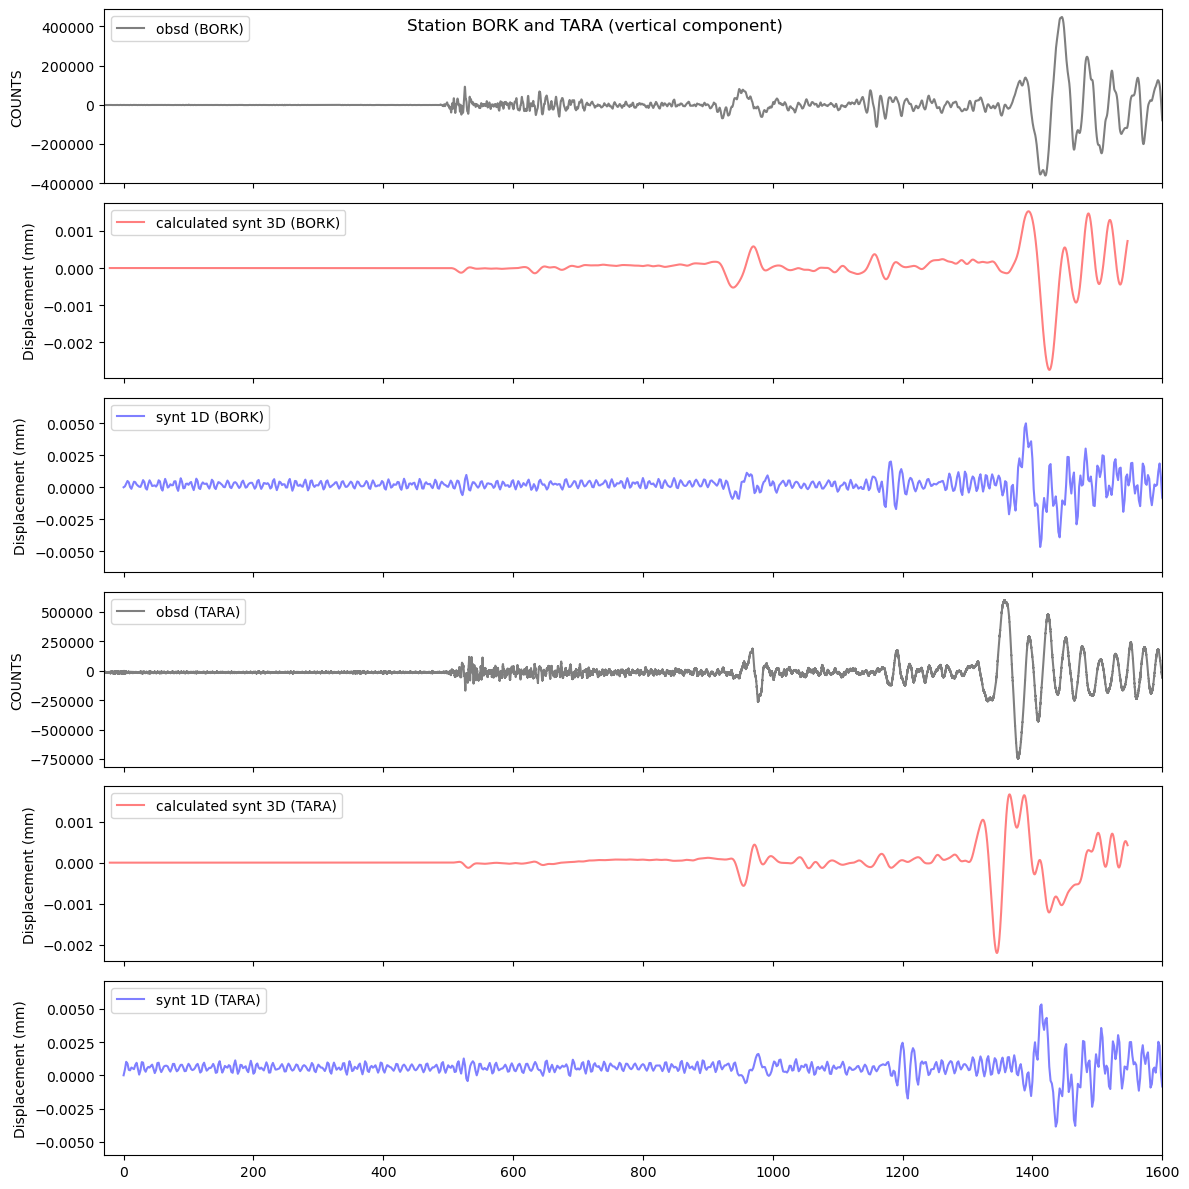

In [11]:
# select one station and plot the observed and synthetic data
tr_obs_bork    = st_obs.select(   station="BORK",channel="*Z")[0]
tr_syn_bork    = st_syn.select(   station="BORK",channel="*Z")[0]
tr_syn_1d_bork = st_syn_1d.select(station="BORK",channel="*Z")[0]
tr_obs_tara    = st_obs.select(   station="TARA",channel="*Z")[0]
tr_syn_tara    = st_syn.select(   station="TARA",channel="*Z")[0]
tr_syn_1d_tara = st_syn_1d.select(station="TARA",channel="*Z")[0]

# origin time
reftime = origin.time

fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(12, 12))
axes[0].plot(tr_obs_bork.times(reftime=reftime), tr_obs_bork.data, "k", label="obsd (BORK)", alpha=0.5)
axes[0].legend(loc=2)
axes[0].set_ylabel("COUNTS")

axes[1].plot(tr_syn_bork.times(reftime=reftime), tr_syn_bork.data, "r", label="calculated synt 3D (BORK)", alpha=0.5)
axes[1].legend(loc=2)
axes[1].set_ylabel("Displacement ({})".format(disp_unit))

axes[2].plot(tr_syn_1d_bork.times(reftime=reftime), tr_syn_1d_bork.data, "b", label="synt 1D (BORK)", alpha=0.5)
axes[2].legend(loc=2)
axes[2].set_ylabel("Displacement ({})".format(disp_unit))

axes[3].plot(tr_obs_tara.times(reftime=reftime), tr_obs_tara.data, "k", label="obsd (TARA)", alpha=0.5)
axes[3].legend(loc=2)
axes[3].set_ylabel("COUNTS")

axes[4].plot(tr_syn_tara.times(reftime=reftime), tr_syn_tara.data, "r", label="calculated synt 3D (TARA)", alpha=0.5)
axes[4].legend(loc=2)
axes[4].set_ylabel("Displacement ({})".format(disp_unit))

axes[5].plot(tr_syn_1d_tara.times(reftime=reftime), tr_syn_1d_tara.data, "b", label="synt 1D (TARA)", alpha=0.5)
axes[5].legend(loc=2)
axes[5].set_ylabel("Displacement ({})".format(disp_unit))


axes[2].set_xlim(-30, 1600)
plt.tight_layout()

# title
plt.suptitle("Station BORK and TARA (vertical component)")



In [12]:
# check the reference time
t_in_1d = tr_syn_1d_bork.times(reftime=reftime)[0]
t_in_3d = tr_syn_bork.times(reftime=reftime)[0]
print(f"initial times: \n3D synthetic={t_in_3d} \n1D synthetic={t_in_1d} ")

initial times: 
3D synthetic=-21.299999 
1D synthetic=-0.04 


## Cutting and Resampling

The downloaded singals are generally cut and resampled for those purposes,
- to reduce the size of the data
- to match the sampling rate and time window of the observed data to the synthetic data

The process for the second purpose is also often done after calculating the adjoint sources,
but in this example, we will do the both at the same time here.

In [13]:
# check the initial state of the observed and synthetic data
print(st_obs.select(station="BORK",channel="*Z")[0])
print(st_syn.select(station="BORK",channel="*Z")[0])
print(st_syn_1d.select(station="BORK",channel="*Z")[0])

II.BORK.00.BHZ | 2024-01-01T07:10:09.144538Z - 2024-01-01T07:40:09.119538Z | 40.0 Hz, 72000 samples
II.BORK.S3.MXZ | 2024-01-01T07:10:17.840001Z - 2024-01-01T07:36:25.700016Z | 7.1 Hz, 11200 samples
II.BORK.S1.LXZ | 2024-01-01T07:10:39.100000Z - 2024-01-01T10:30:37.100000Z | 0.5 Hz, 6000 samples


In [14]:

# function which adjust the length of the traces and sample rate
# of the observed and synthetic traces
st_obs.taper(max_percentage=0.05, type="cosine")

# use the same sampling rate for both traces
st_obs.interpolate(sampling_rate=st_syn[0].stats.sampling_rate,
                   starttime=st_syn[0].stats.starttime)

# adjust the length of the traces
npts_syn = st_syn[0].stats.npts
for tr in st_obs:
    if tr.stats.npts > npts_syn:
        tr.data = tr.data[:npts_syn]
    else:
        tr.data = np.pad(tr.data, (0, npts_syn-tr.stats.npts), mode="constant", constant_values=0)

# 1d synthetic trace is trimmed to the same start and end time (only for comparison)
st_syn_1d.trim(starttime=st_syn[0].stats.starttime, endtime=st_syn[0].stats.endtime, pad=False)

# check the contents of the data after processing
print(st_obs.select(station="BORK",channel="*Z")[0])
print(st_syn.select(station="BORK",channel="*Z")[0])


II.BORK.00.BHZ | 2024-01-01T07:10:17.840001Z - 2024-01-01T07:36:25.700016Z | 7.1 Hz, 11200 samples
II.BORK.S3.MXZ | 2024-01-01T07:10:17.840001Z - 2024-01-01T07:36:25.700016Z | 7.1 Hz, 11200 samples


Text(0.5, 0.98, 'Station BORK and TARA (vertical component)')

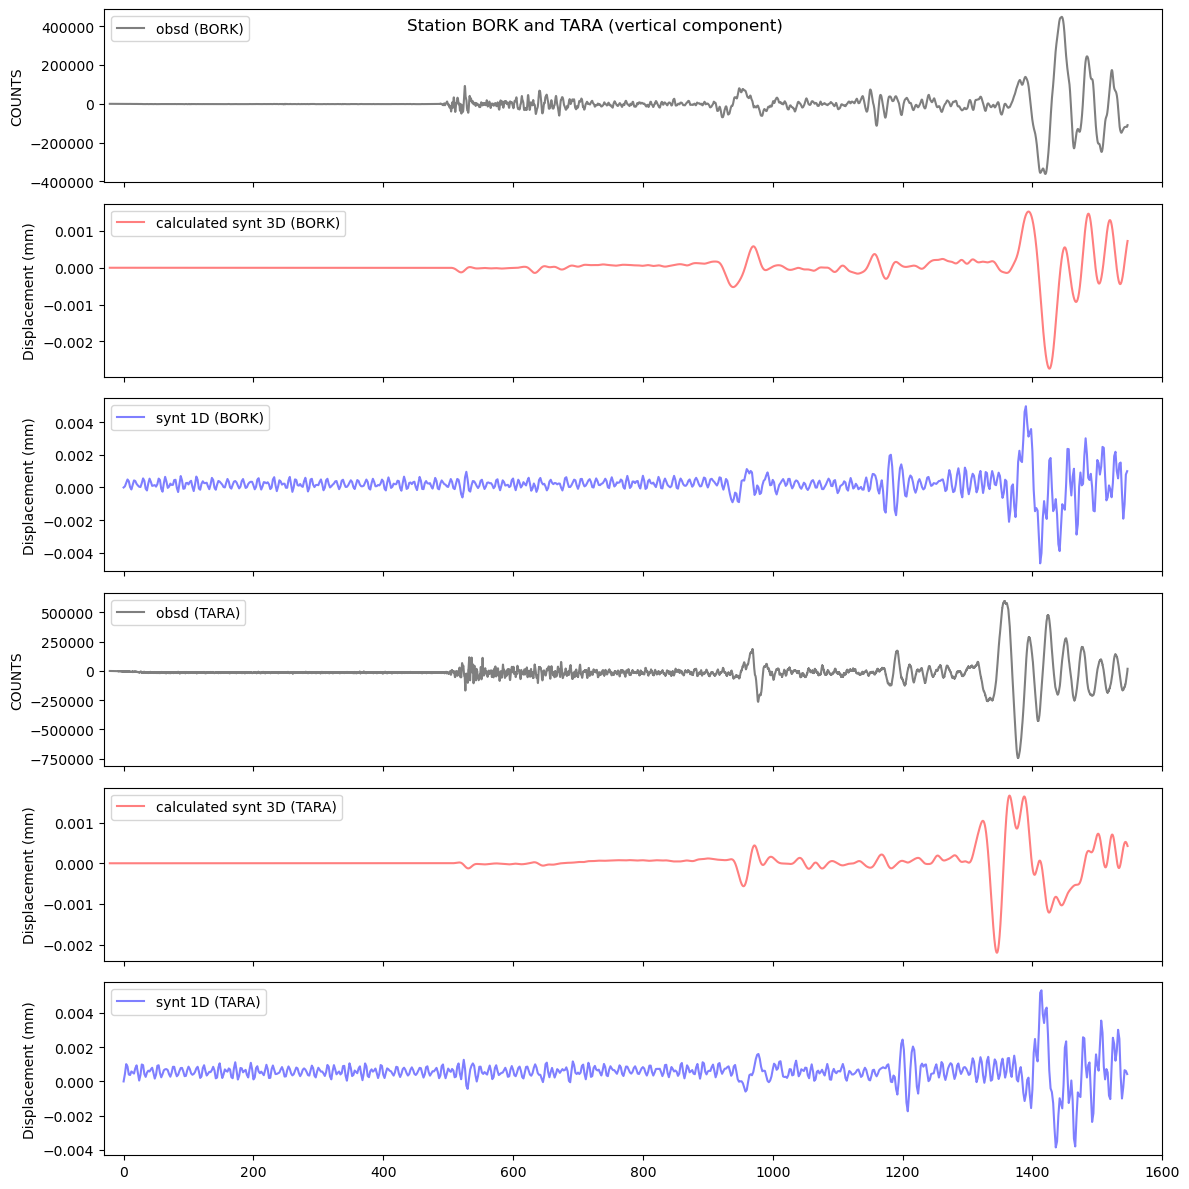

In [15]:
tr_obs_bork = st_obs.select(station="BORK",channel="*Z")[0]
tr_syn_bork = st_syn.select(station="BORK",channel="*Z")[0]
tr_obs_tara = st_obs.select(station="TARA",channel="*Z")[0]
tr_syn_tara = st_syn.select(station="TARA",channel="*Z")[0]

# event time
reftime = origin.time

fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(12, 12))
axes[0].plot(tr_obs_bork.times(reftime=reftime), tr_obs_bork.data, "k", label="obsd (BORK)", alpha=0.5)
axes[0].legend(loc=2)
axes[0].set_ylabel("COUNTS")

axes[1].plot(tr_syn_bork.times(reftime=origin.time), tr_syn_bork.data, "r", label="calculated synt 3D (BORK)", alpha=0.5)
axes[1].legend(loc=2)
axes[1].set_ylabel("Displacement ({})".format(disp_unit))

axes[2].plot(tr_syn_1d_bork.times(reftime=origin.time), tr_syn_1d_bork.data, "b", label="synt 1D (BORK)", alpha=0.5)
axes[2].legend(loc=2)
axes[2].set_ylabel("Displacement ({})".format(disp_unit))

axes[3].plot(tr_obs_tara.times(reftime=reftime), tr_obs_tara.data, "k", label="obsd (TARA)", alpha=0.5)
axes[3].legend(loc=2)
axes[3].set_ylabel("COUNTS")

axes[4].plot(tr_syn_tara.times(reftime=origin.time), tr_syn_tara.data, "r", label="calculated synt 3D (TARA)", alpha=0.5)
axes[4].legend(loc=2)
axes[4].set_ylabel("Displacement ({})".format(disp_unit))

axes[5].plot(tr_syn_1d_tara.times(reftime=origin.time), tr_syn_1d_tara.data, "b", label="synt 1D (TARA)", alpha=0.5)
axes[5].legend(loc=2)
axes[5].set_ylabel("Displacement ({})".format(disp_unit))

axes[5].set_xlim(-30, 1600)
plt.tight_layout()

# title
plt.suptitle("Station BORK and TARA (vertical component)")

## Filtering and Removing Instrument Response

Observed data:

$$
obsd = \text{source} * \text{model} * \text{instrument}
$$

Synthetic data:

$$
synt = \text{source} * \text{model}
$$

In order to compare the data, we need to deconvolve the instrument response from observed data and filter both data to a comparable frequency range.

We downloaded *StationXML* files with the seismic data. These files contain information about stations like location and response function. We can use this information to remove the instrument response.

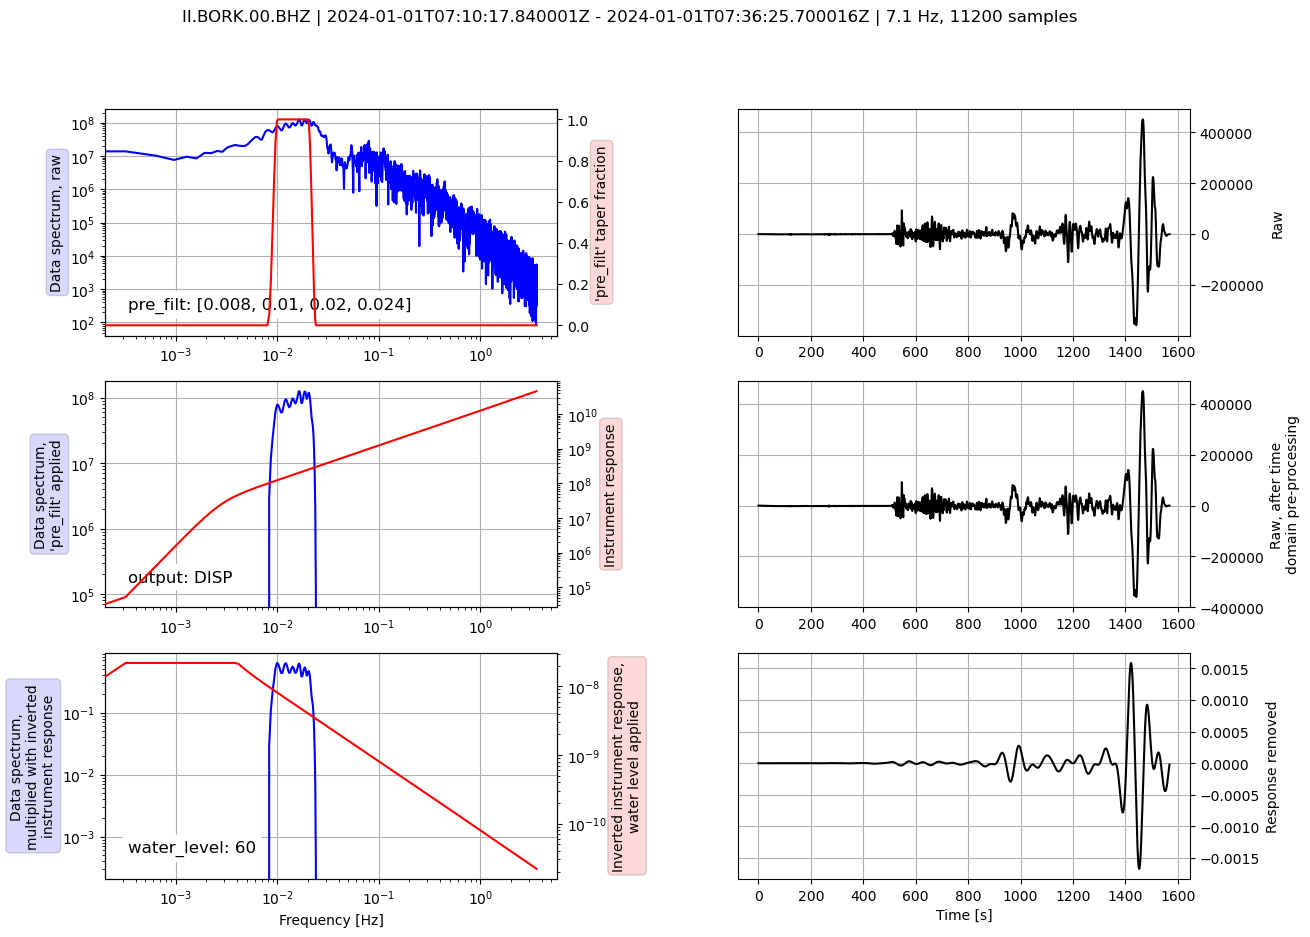

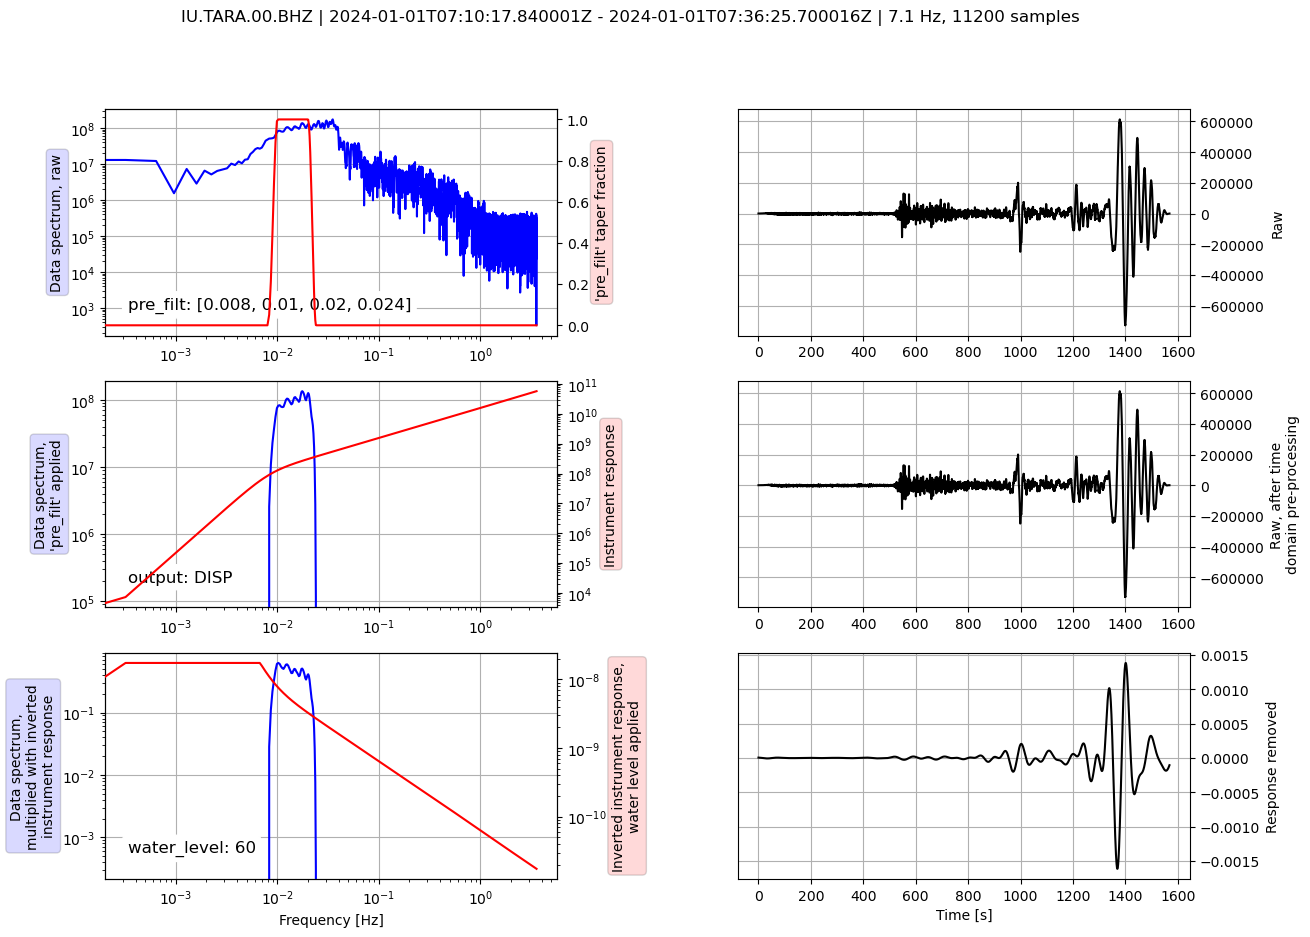

In [16]:
# Reading the instrument data

# frequency band for the bandpass filter
min_period = 50
max_period = 100
freqmin = 1.0/max_period
freqmax = 1.0/min_period
pre_filt = (0.8*freqmin, freqmin, freqmax, 1.2*freqmax)

# directory path to the instrument response files
dir_path_inv = f"./data/{eqname}/stations"

# process the observed data by each trace
for tr in st_obs:
    network = tr.stats.network
    station = tr.stats.station
    channel = tr.stats.channel
    # read the instrument response file
    inv = obspy.read_inventory(f"{dir_path_inv}/{network}.{station}.xml")
    # attach the instrument response to the trace
    tr.attach_response(inv)

    # add coordinates to the trace
    tr.stats.latitude = inv[0][0].latitude
    tr.stats.longitude = inv[0][0].longitude
    tr.stats.elevation = inv[0][0].elevation

    # change channel name from BH1 to BHN, BH2 to BHE (only for rotation with obspy)
    if tr.stats.channel == "BH1":
        tr.stats.channel = "BHN"
    elif tr.stats.channel == "BH2":
        tr.stats.channel = "BHE"

    # remove mean and linear trend
    tr.detrend("demean")
    tr.detrend("linear")
    # taper
    tr.taper(max_percentage=0.05, type="cosine")

    # plot the result if the trace is vertical
    if tr.stats.channel[-1] == "Z":
        plot = True
    else:
        plot = False

    # remove the instrument response with a pre-filter
    tr.remove_response(output="DISP", pre_filt=pre_filt, water_level=60, plot=plot)


In [17]:
# use sac taper on synthetic data

def sac_taper(tr):
    data = tr.data.astype(np.float64)
    nfft = _npts2nfft(len(tr.data))
    data = np.fft.rfft(tr.data, nfft)
    fy = 1.0 / (tr.stats.delta * 2.0)
    freqs = np.linspace(0, fy, nfft//2+1)
    data *= cosine_sac_taper(freqs, flimit=pre_filt)
    data[-1] = abs(data[-1]) + 0.0j
    tr.data = np.fft.irfft(data)[0:len(tr.data)]

st_syn.detrend("linear")
st_syn.detrend("demean")
st_syn.taper(0.05, type="cosine")

for tr in st_syn:
    sac_taper(tr)

st_syn_1d.detrend("linear")
st_syn_1d.detrend("demean")
st_syn_1d.taper(0.05, type="cosine")

for tr in st_syn_1d:
    sac_taper(tr)

## Final Comparisons
Finally, we can compare the observed and synthetic data.

Text(0.5, 0.98, 'Station BORK and TARA (vertical component)')

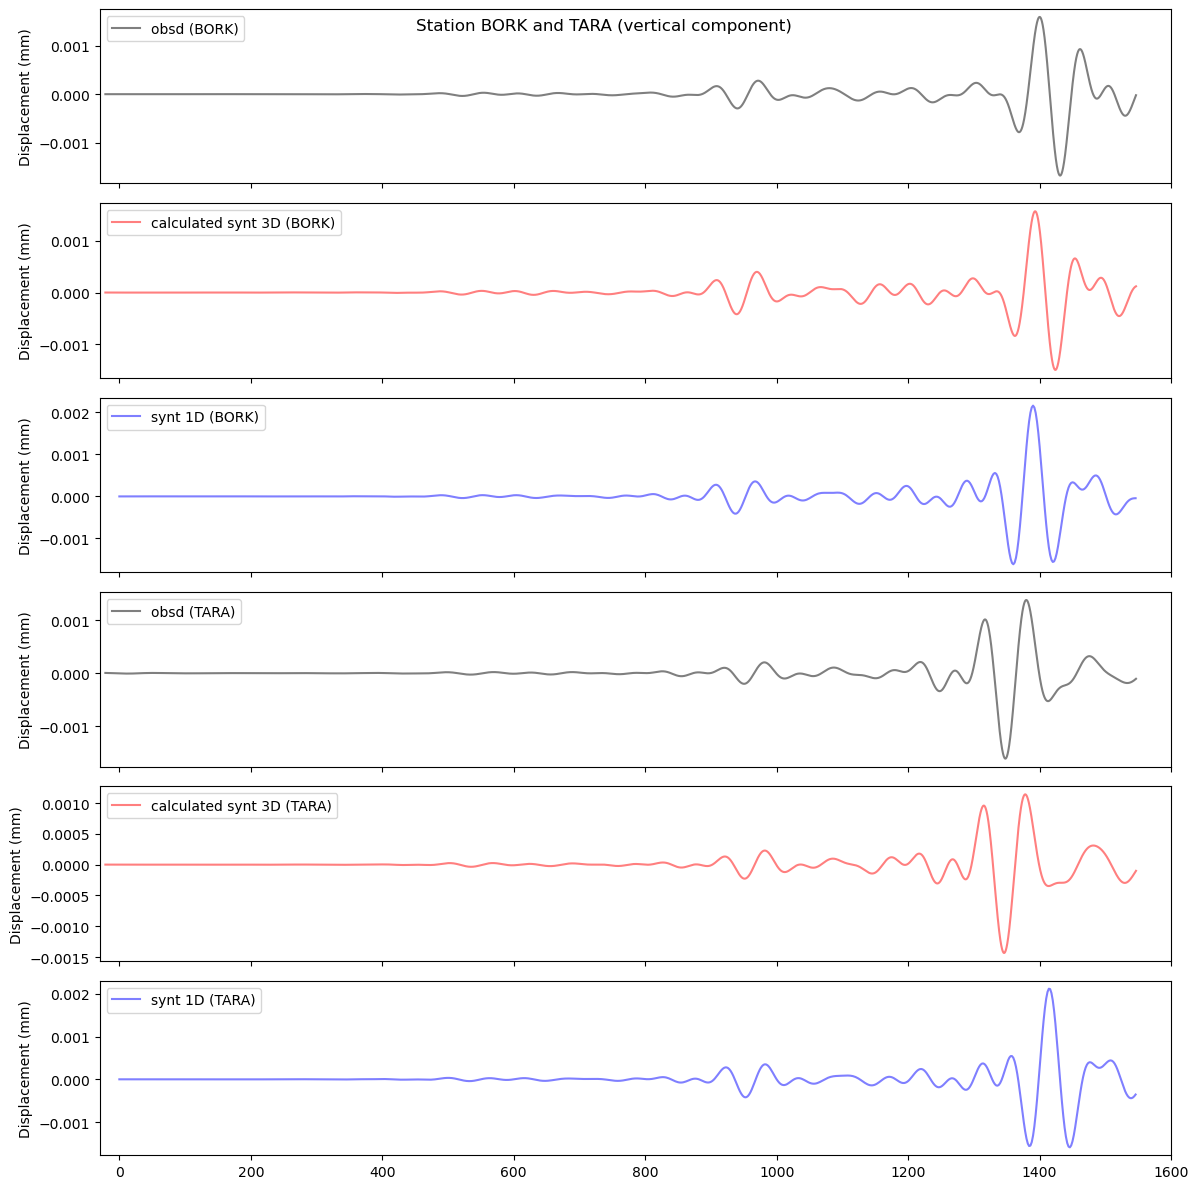

In [18]:
tr_obs_bork    = st_obs.select(   station="BORK",channel="*Z")[0]
tr_syn_bork    = st_syn.select(   station="BORK",channel="*Z")[0]
tr_syn_1d_bork = st_syn_1d.select(station="BORK",channel="*Z")[0]
tr_obs_tara    = st_obs.select(   station="TARA",channel="*Z")[0]
tr_syn_tara    = st_syn.select(   station="TARA",channel="*Z")[0]
tr_syn_1d_tara = st_syn_1d.select(station="TARA",channel="*Z")[0]

reftime = origin.time

fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(12, 12))
axes[0].plot(tr_obs_bork.times(reftime=reftime), tr_obs_bork.data, "k", label="obsd (BORK)", alpha=0.5)
axes[0].legend(loc=2)
axes[0].set_ylabel("Displacement ({})".format(disp_unit))

axes[1].plot(tr_syn_bork.times(reftime=reftime), tr_syn_bork.data, "r", label="calculated synt 3D (BORK)", alpha=0.5)
axes[1].legend(loc=2)
axes[1].set_ylabel("Displacement ({})".format(disp_unit))

axes[2].plot(tr_syn_1d_bork.times(reftime=reftime), tr_syn_1d_bork.data, "b", label="synt 1D (BORK)", alpha=0.5)
axes[2].legend(loc=2)
axes[2].set_ylabel("Displacement ({})".format(disp_unit))

axes[3].plot(tr_obs_tara.times(reftime=reftime), tr_obs_tara.data, "k", label="obsd (TARA)", alpha=0.5)
axes[3].legend(loc=2)
axes[3].set_ylabel("Displacement ({})".format(disp_unit))

axes[4].plot(tr_syn_tara.times(reftime=reftime), tr_syn_tara.data, "r", label="calculated synt 3D (TARA)", alpha=0.5)
axes[4].legend(loc=2)
axes[4].set_ylabel("Displacement ({})".format(disp_unit))

axes[5].plot(tr_syn_1d_tara.times(reftime=reftime), tr_syn_1d_tara.data, "b", label="synt 1D (TARA)", alpha=0.5)
axes[5].legend(loc=2)
axes[5].set_ylabel("Displacement ({})".format(disp_unit))

axes[5].set_xlim(-30, 1600)
fig.tight_layout()
# title
plt.suptitle("Station BORK and TARA (vertical component)")



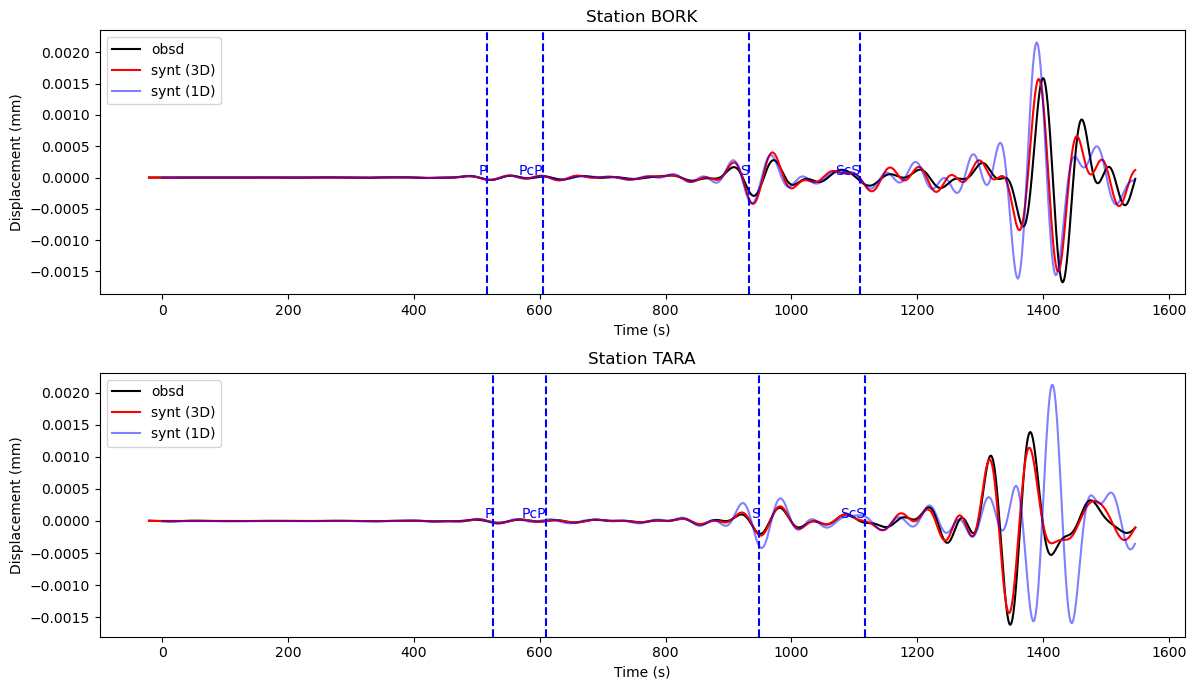

In [19]:
# plot the observed and synthetic data by overlaying them

reftime = origin.time

fig, ax = plt.subplots(2,1 , figsize=(12, 7))
ax[0].plot(tr_obs_bork.times(reftime=reftime),    tr_obs_bork.data, "k", label="obsd")
ax[0].plot(tr_syn_bork.times(reftime=reftime),    tr_syn_bork.data, "r", label="synt (3D)")
ax[0].plot(tr_syn_1d_bork.times(reftime=reftime), tr_syn_1d_bork.data, "b", label="synt (1D)", alpha=0.5)
ax[0].legend(loc=2)
ax[0].set_ylabel("Displacement ({})".format(disp_unit))
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Station BORK")
ax[1].plot(tr_obs_tara.times(reftime=reftime),    tr_obs_tara.data, "k", label="obsd")
ax[1].plot(tr_syn_tara.times(reftime=reftime),    tr_syn_tara.data, "r", label="synt (3D)")
ax[1].plot(tr_syn_1d_tara.times(reftime=reftime), tr_syn_1d_tara.data, "b", label="synt (1D)", alpha=0.5)
ax[1].legend(loc=2)
ax[1].set_ylabel("Displacement ({})".format(disp_unit))
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Station TARA")

# add P- and S-wave arrivals
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
arrivals_bork = model.get_ray_paths(
    source_depth_in_km=origin.depth/1000,
    distance_in_degree=locations2degrees(origin.latitude, origin.longitude,
                                         tr_syn_bork.stats.sac["stla"], tr_syn_bork.stats.sac["stlo"]),
    phase_list=["P", "S", "PcP", "ScS"])
arrivals_tara = model.get_ray_paths(
    source_depth_in_km=origin.depth/1000,
    distance_in_degree=locations2degrees(origin.latitude, origin.longitude,
                                         tr_syn_tara.stats.sac["stla"], tr_syn_tara.stats.sac["stlo"]),
    phase_list=["P", "S", "PcP", "ScS"])

# draw the arrivals
for arrival in arrivals_bork:
    ax[0].axvline(arrival.time, color="blue", linestyle="--")
    ax[0].text(arrival.time, 0, arrival.name, va="bottom", ha="right", color="blue")

for arrival in arrivals_tara:
    ax[1].axvline(arrival.time, color="blue", linestyle="--")
    ax[1].text(arrival.time, 0, arrival.name, va="bottom", ha="right", color="blue")

plt.tight_layout()

## Finding the time shift

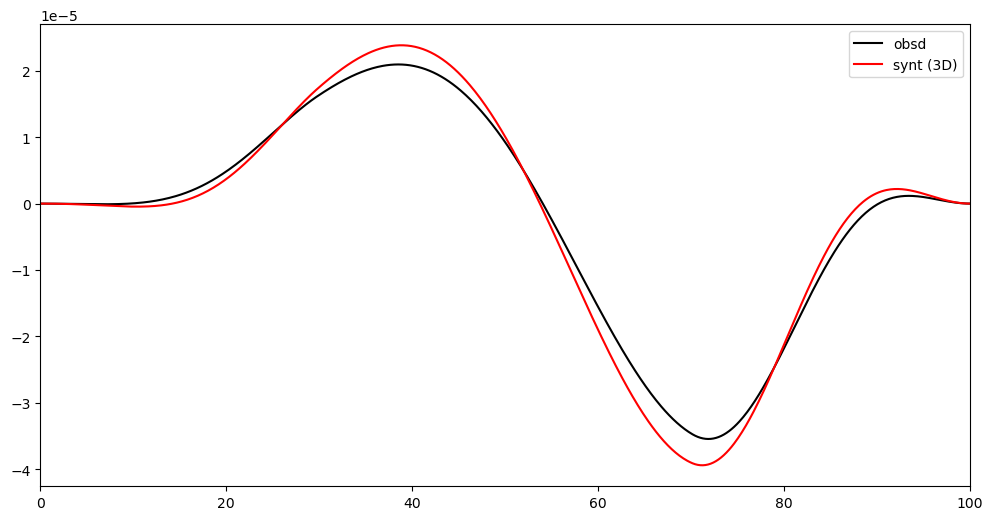

In [20]:
# Cut the data
tmin, tmax = 470, 570
obsd_sw = tr_obs_bork.copy()
obsd_sw.trim(obsd_sw.stats.starttime+tmin, obsd_sw.stats.starttime+tmax)
obsd_sw.taper(0.3, type="cosine")

synt3d_sw = tr_syn_bork.copy()
synt3d_sw.trim(synt3d_sw.stats.starttime+tmin, synt3d_sw.stats.starttime+tmax)
synt3d_sw.taper(0.3, type="cosine")


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(obsd_sw.times(), obsd_sw.data, "k", label="obsd")
ax.plot(synt3d_sw.times(), synt3d_sw.data, "r", label="synt (3D)")
ax.set_xlim(0, tmax-tmin)
ax.legend();

In [21]:
def xcorr_shift(d, s):
    "Returns the time shift where the crosscorrelation is maximum"
    cc = np.correlate(d.data, s.data, mode="full")
    time_shift = cc.argmax() - len(d.data) + 1
    return time_shift*d.stats.delta

# Find the time shifts between the data
shift3d = xcorr_shift(obsd_sw, synt3d_sw)
print(f"time shift: {shift3d:5.1f} ")

time shift:   0.6 


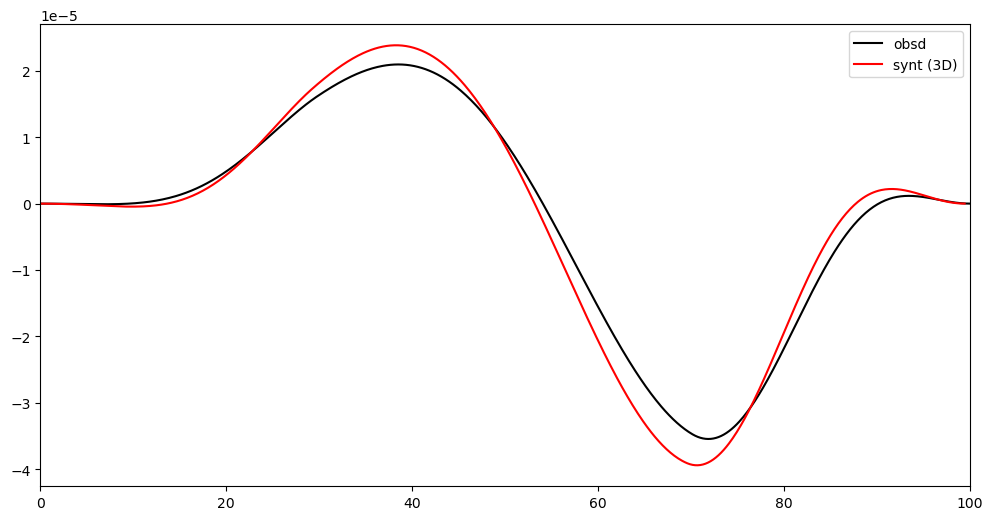

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(obsd_sw.times(), obsd_sw.data, "k", label="obsd")
ax.plot(synt3d_sw.times()-shift3d, synt3d_sw.data, "r", label="synt (3D)")
ax.set_xlim(0,tmax-tmin)
ax.legend();

## calculating the misfit and adjoint sources

In [23]:
# preproces
import obspy.geodetics

def preprocess_before_adjoint_source_calculation(st,ev,obs_data=True):
    # perform ENZ to RTZ rotation for the synthetic and observed data

    list_st_names = list(set([tr.stats.station for tr in st]))
    for st_name in list_st_names:
        # calculate the back azimuth
        if obs_data:
            # calculate the back azimuth by using the event and station coordinates
            baz = obspy.geodetics.gps2dist_azimuth(ev.origins[0].latitude,ev.origins[0].longitude,
                                                    st.select(station=st_name)[0].stats.latitude,
                                                    st.select(station=st_name)[0].stats.longitude)[2]
        else:
            # synthetic data contains the back azimuth information
            baz = st.select(station=st_name)[0].stats.sac["baz"]

        st.select(station=st_name).rotate(method="NE->RT", back_azimuth=baz)

# rotate the traces
# observed data
preprocess_before_adjoint_source_calculation(st_obs, event, obs_data=True)
# synthetic data
preprocess_before_adjoint_source_calculation(st_syn, event, obs_data=False)

/tmp/ipykernel_375760/1623462568.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  baz = obspy.geodetics.gps2dist_azimuth(ev.origins[0].latitude,ev.origins[0].longitude,


Text(0.5, 1.0, 'Window tapers with taper percentage 0.6')

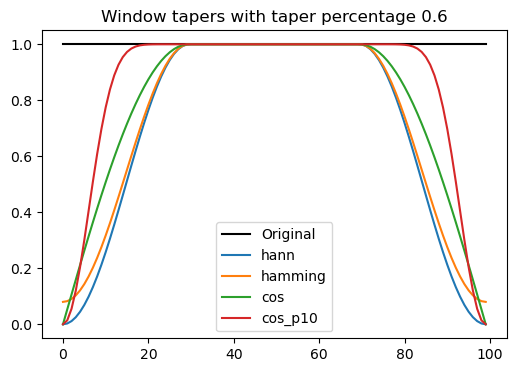

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# custom window functions
def window_taper(signal, taper_percentage, taper_type):
    npts = len(signal)
    frac = int(npts * taper_percentage / 2.0 + 0.5)

    idx1 = frac
    idx2 = npts - frac

    if taper_type == "hann":
        window = 0.5 - 0.5 * np.cos(2.0 * np.pi * np.arange(0, 2 * frac) / (2 * frac - 1))
    elif taper_type == "hamming":
        window = 0.54 - 0.46 * np.cos(2.0 * np.pi * np.arange(0, 2 * frac) / (2 * frac - 1))
    elif taper_type == "cos":
        window = np.cos(np.pi * np.arange(0, 2 * frac) / (2 * frac - 1) - np.pi / 2.0)
    elif taper_type == "cos_p10":
        window = 1. - np.cos(np.pi * np.arange(0, 2 * frac) / (2 * frac - 1)) ** 10

    signal[:idx1] *= window[:frac]
    signal[idx2:] *= window[frac:]

    # return test signal
    test = np.ones(npts)
    test[:idx1] = window[:frac]
    test[idx2:] = window[frac:]

    return signal, test

# test the window taper functions
npts = 100
taper_percentage = 0.6
signal = np.ones(npts)
taper_types = ["hann", "hamming", "cos", "cos_p10"]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(signal, 'k', label='Original')

for taper_type in taper_types:
    signal_tapered, _ = window_taper(signal.copy(), taper_percentage, taper_type)
    ax.plot(signal_tapered, label=taper_type)

ax.legend()
ax.set_title(f'Window tapers with taper percentage {taper_percentage}')

## Varieties of Misfit Functions

Always be careful about the sign of the adjoint sources!!!
### Normalized Waveform Misfit:

Misfit function 
$$
\chi(m) = \frac{1}{2} \sum_{i=1}^{N_r} \frac{\int_0^T [d_i(t) - s_i(t,m)]^2 dt}{\int d_i^2(t) dt} 
$$
Adjoint source for i-th station
$$
f_i^\dagger(t) = \frac{-(d_i(t) - s_i(t,m))}{\int_0^T d_i^2(t) dt} 
$$

### Traveltime Misfit:

Misfit function
$$
\chi = \frac{1}{2} \sum_{i=0}^{N_r} [T^{obs}_{i} - T^{syn}_{i}]^2
$$
Adjoint source for i-th station
$$
f^{\dagger}_i(t) = - \frac{1}{N} ~ \left[ T^{obs}_{i} - T^{syn}_{i} \right] ~ 
\partial_t s_i(t,m),
$$

where 
$$
N = \int_0^T ~ s_i(t,m) ~
\partial^2_t s_i(t,m) dt.
$$


### Amplitude Misfit:

Misfit function
$$
\chi = \frac{1}{2} \sum_{i=0}^{N_r} \left[ \ln \left( \frac{A^{obs}_i}{A^{syn}_i(m)} \right) \right]^2
$$
Adjoint source for i-th station
$$
f^{\dagger}_i(t) = - \frac{1}{M_i} ~ \left[ \ln \left( \frac{A^{obs}_i}{A^{syn}_i(m)} \right) \right] s_i(t),
$$

where
$$
M_i = \int_0^T s_i^2(t,m)dt
$$





In [25]:
from scipy.integrate import simpson

# available adjoint source types
available_adjtype = ['waveform', 'traveltime', 'amplitude']

# cross-correlation function to calculate the time shift
def xcorr_shift(d, s):
    cc = np.correlate(d, s, mode="full")
    time_shift = cc.argmax() - len(d) + 1
    return time_shift

# function to calculate adjoint source
def calculate_adjoint_source(_tr_obs, _tr_syn, origin, tmin, tmax,
                             plot=False, adjtype='waveform', taper_percentage=0.3, win_type='cos_p10'):
    """
    Calculate adjoint source
    tmin and tmax are the window range in seconds for the adjoint source calculation, starting from the first data point of the trace
    """

    if adjtype not in available_adjtype:
        print(f"adjtype {adjtype} is not available. Please choose from {available_adjtype}")
        return None

    # copy the observed and synthetic data
    tr_obs = _tr_obs.copy()
    tr_syn = _tr_syn.copy()

    # event time
    event_time = origin.time

    # window range in datetime format
    tr_obs.trim(starttime=tr_obs.stats.starttime+tmin, endtime=tr_obs.stats.starttime+tmax)
    tr_syn.trim(starttime=tr_syn.stats.starttime+tmin, endtime=tr_syn.stats.starttime+tmax)
    tr_obs.data, _ = window_taper(tr_obs.data, taper_percentage, win_type)
    tr_syn.data, _ = window_taper(tr_syn.data, taper_percentage, win_type)

    # check if the observed and synthetic data have the same data length and sampling rate
    if tr_obs.stats.npts != tr_syn.stats.npts:
        print(f"Observed and synthetic data have different data length: {tr_obs.stats.npts} and {tr_syn.stats.npts}")
        return None

    if tr_obs.stats.sampling_rate != tr_syn.stats.sampling_rate:
        print(f"Observed and synthetic data have different sampling rate: {tr_obs.stats.sampling_rate} and {tr_syn.stats.sampling_rate}")
        return None

    # calculate adjoint source
    s, e = _tr_syn.stats.starttime, _tr_syn.stats.endtime
    tr_adj = tr_syn.copy()

    if adjtype == 'waveform':
        # calculate the misfit function
        misfit = 0.5*simpson((tr_obs.data - tr_syn.data) ** 2, dx=tr_obs.stats.delta)

        # normalization factor
        norm_w = simpson(tr_obs.data**2, dx=tr_obs.stats.delta)

        # calculate the adjoint source = - factor*(observed - synthetic)
        tr_adj.data = -norm_w * (tr_obs.data - tr_syn.data)

    elif adjtype == 'traveltime':
        # calculate time shift and amplitude anomaly by cross-correlation
        ishift = xcorr_shift(tr_obs.data, tr_syn.data)
        tshift = ishift * tr_syn.stats.delta

        # misfit function for the time shift and amplitude anomaly
        misfit = 0.5 * tshift**2

        # calculate the derivative of the current displacement
        _v = np.gradient(tr_syn.data, tr_syn.stats.delta)

        # normalization factor
        norm_t = simpson(tr_syn.data * _v**2, dx=tr_syn.stats.delta)

        # calculate traveltime adjoint source
        tr_adj.data = -tshift * _v / norm_t

    elif adjtype == 'amplitude':
        # calculate amplitude ratio by cross-correlation
        ishift = xcorr_shift(tr_obs.data, tr_syn.data)

        # shift the synthetic data and keep the length
        tr_syn.data = np.roll(tr_syn.data, -ishift)

        # amplitude ratio
        amp_ratio = np.sum(tr_obs.data*tr_syn.data) / np.sum(tr_syn.data**2)

        # misfit
        misfit = 0.5 * (np.log(amp_ratio) ** 2)

        # normalization factor
        norm_a = simpson(tr_syn.data**2, dx=tr_syn.stats.delta)

        # calculate amplitude adjoint source
        tr_adj.data = -1.0 * np.log(amp_ratio) * tr_syn.data / norm_a


    # taper the adjoint source
    tr_adj.data, wtest = window_taper(tr_adj.data, taper_percentage, win_type)
    tr_adj.trim(starttime=s, endtime=e, pad=True, fill_value=0.0)

    if plot:
        # copy traces for plotting
        tr_obs_plot = _tr_obs.copy()
        tr_syn_plot = _tr_syn.copy()

        # start time of the traces is different
        tr_st_diff_obs = tr_obs_plot.stats.starttime - event_time
        tr_st_diff_syn = tr_syn_plot.stats.starttime - event_time

        # abort if tr_st_diff_obs and tr_st_diff_syn are not the same
        if tr_st_diff_obs != tr_st_diff_syn:
            print(f"Start time difference between observed and synthetic data is not the same: {tr_st_diff_obs} and {tr_st_diff_syn}")
            return None

        # plot tr_obs and tr_syn on axs[0] (whole signal), axs[1] (around the window), then plot tr_adj on axs[2]
        fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=False)

        axs[0].plot(tr_obs_plot.times(), tr_obs_plot.data, 'k', label='Observed')
        axs[0].plot(tr_syn_plot.times(), tr_syn_plot.data, 'r', label='Synthetic')
        axs[0].set_title(f"Station (obs) {tr_obs.stats.station} {tr_obs.stats.channel} - (syn) {tr_syn.stats.station} {tr_syn.stats.channel}")
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('Displacement (m)')
        axs[0].legend()

        axs[1].plot(tr_obs_plot.times(), tr_obs_plot.data, 'k', label='Observed')
        axs[1].plot(tr_syn_plot.times(), tr_syn_plot.data, 'r', label='Synthetic')
        axs[1].set_title(f"Station (obs) {tr_obs.stats.station} {tr_obs.stats.channel} - (syn) {tr_syn.stats.station} {tr_syn.stats.channel}")
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('Displacement (m)')
        axs[1].legend()

        axs[2].plot(tr_adj.times(), tr_adj.data, 'k', label='Adjoint source')
        axs[2].set_title(f"Adjoint source, type: {adjtype}, misfit: {misfit:.4e}")
        axs[2].set_xlabel('Time (s)')
        #axs[2].set_ylabel('Displacement (m)')
        axs[2].legend()

        # set xlim
        xmin = tmin*0.8
        xmax = tmax*1.2

        axs[0].set_xlim(tr_adj.times()[0], tr_adj.times()[-1])
        axs[1].set_xlim(xmin, xmax)
        axs[2].set_xlim(xmin, xmax)

        # take max and min of the data in xrange
        vmin = min(tr_obs_plot.data[(tr_obs_plot.times() > xmin) & (tr_obs_plot.times() < xmax)].min(),
                   tr_syn_plot.data[(tr_syn_plot.times() > xmin) & (tr_syn_plot.times() < xmax)].min())*1.3
        vmax = max(tr_obs_plot.data[(tr_obs_plot.times() > xmin) & (tr_obs_plot.times() < xmax)].max(),
                   tr_syn_plot.data[(tr_syn_plot.times() > xmin) & (tr_syn_plot.times() < xmax)].max())*1.3

        axs[1].set_ylim(vmin, vmax)

        # check vmin and vmax between xmin and xmax for entire signal
        vmin_whole = min(tr_obs_plot.data.min(), tr_syn_plot.data.min())*1.3
        vmax_whole = max(tr_obs_plot.data.max(), tr_syn_plot.data.max())*1.3

        # check vmin and vmax between xmin and xmax for adjoint source
        vmin_adj = tr_adj.data.min()*1.3
        vmax_adj = tr_adj.data.max()*1.3

        # vertical lines for the taper region
        for i in range(3):
            axs[i].axvline(tmin, color='grey', linestyle='--')
            axs[i].axvline(tmax, color='grey', linestyle='--', label='Taper region')

        # change background color for the taper region with wtest_obs value
        for i in range(3):
            x, y = np.meshgrid(np.linspace(tmin,tmax,100), np.linspace(vmin, vmax,100))
            if i == 0:
                extent = [tmin, tmax, vmin_whole, vmax_whole]
            elif i == 1:
                extent = [tmin, tmax, vmin, vmax]
            else:
                extent = [tmin, tmax, vmin_adj, vmax_adj]
            # z from wtime_obs
            axs[i].imshow(wtest.reshape(1,-1), extent=extent, aspect='auto', cmap='Greys', alpha=0.3)


        plt.tight_layout()
        plt.show()

    return tr_adj, misfit


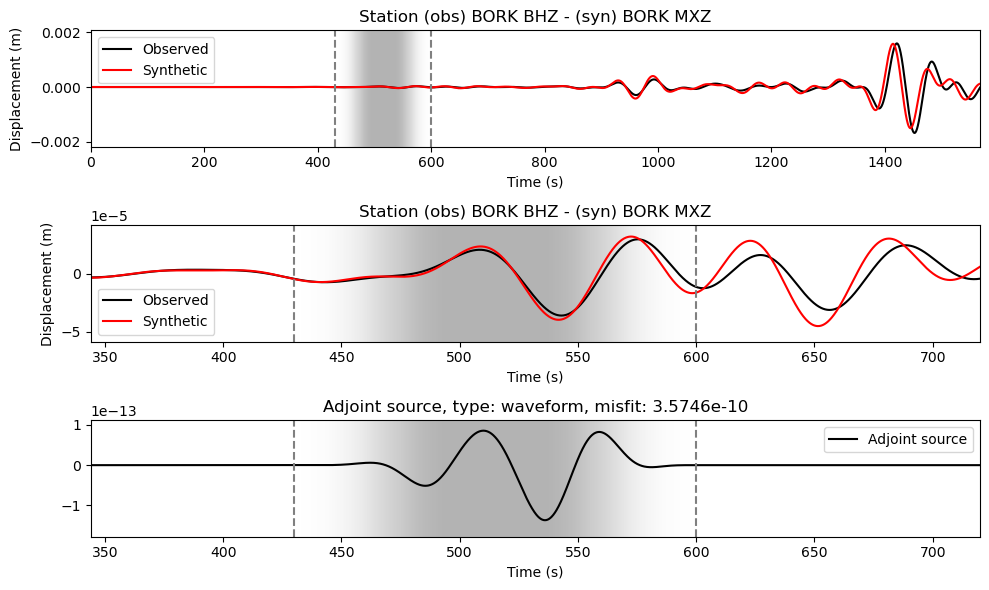

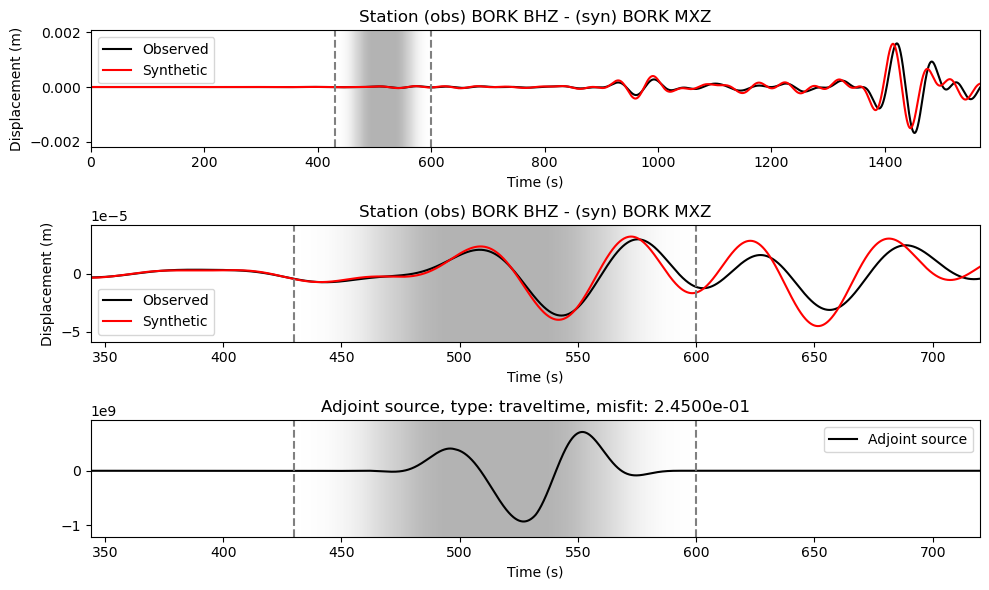

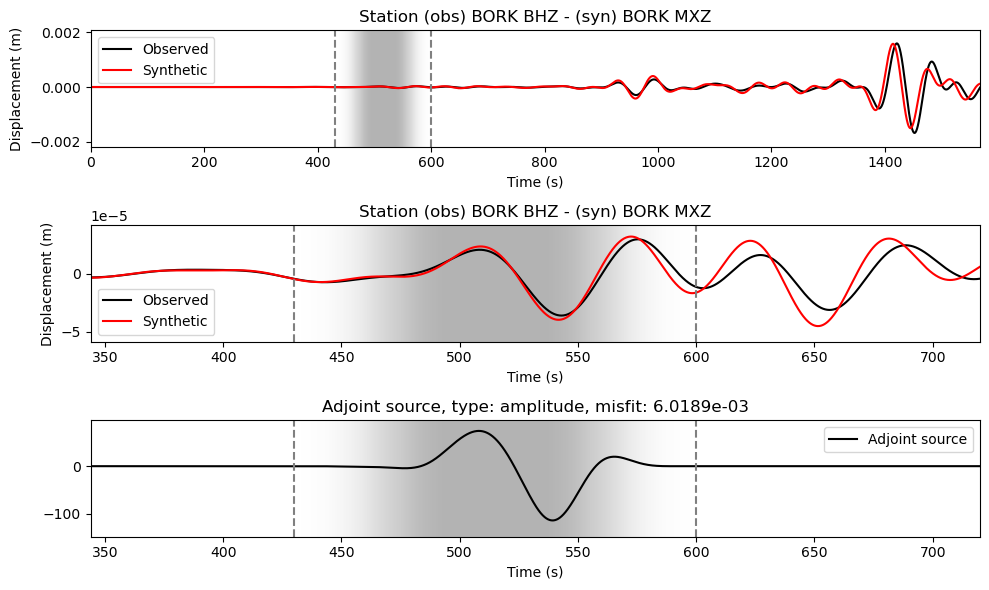

In [26]:
# calculate adjoint source for 'BORK' station
test_tr_syn = st_syn.select(station='BORK', channel='MXZ')[0].copy()
test_tr_obs = st_obs.select(station='BORK', channel='BHZ')[0].copy()

twin_BORK = [430, 600]
taper_percentage_BORK=0.8 # window length * taper_percentage / 2 is the taper length of the initial and final part of the window
win_type='hann'
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_BORK[0], twin_BORK[1], plot=True, adjtype='waveform',   taper_percentage=taper_percentage_BORK, win_type=win_type)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_BORK[0], twin_BORK[1], plot=True, adjtype='traveltime', taper_percentage=taper_percentage_BORK, win_type=win_type)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_BORK[0], twin_BORK[1], plot=True, adjtype='amplitude',  taper_percentage=taper_percentage_BORK, win_type=win_type)

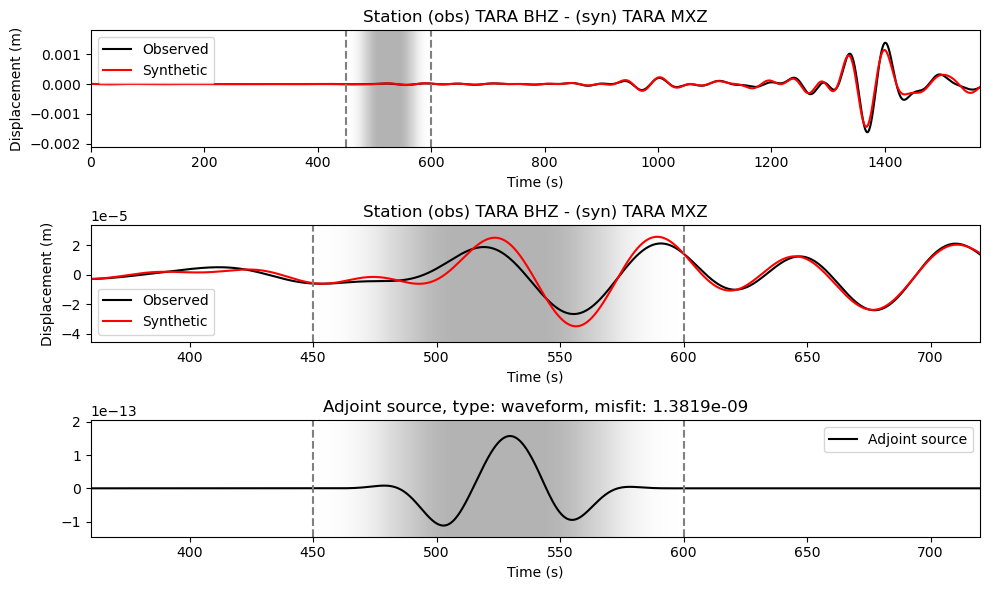

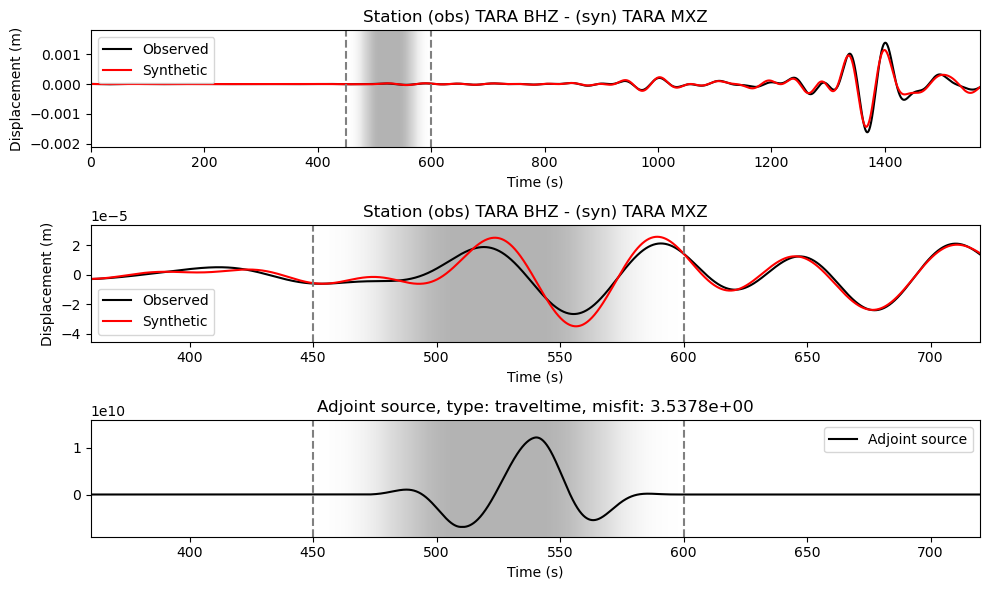

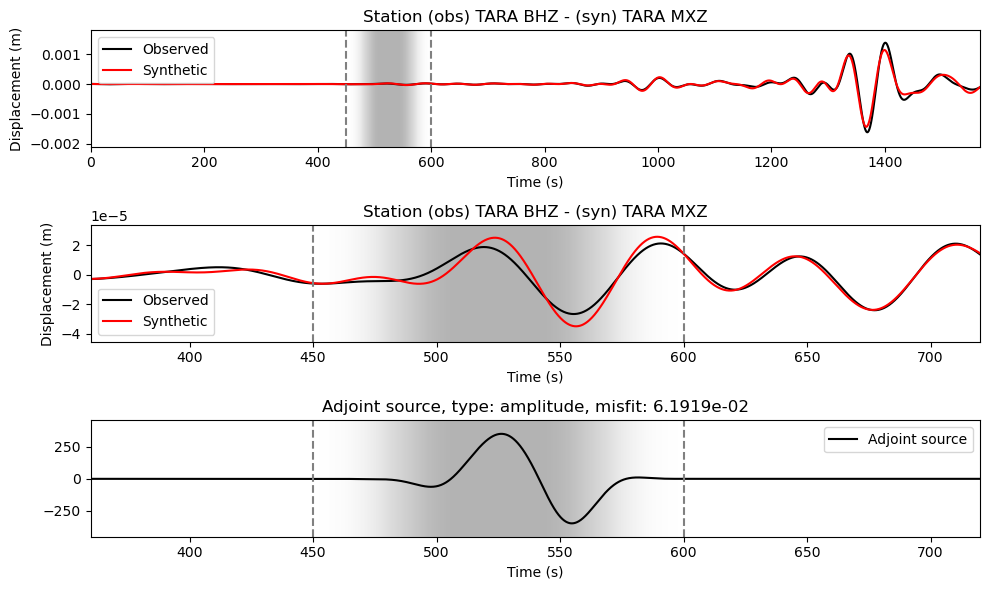

In [27]:
# for TARA station
test_tr_syn = st_syn.select(station='TARA', channel='MXZ')[0].copy()
test_tr_obs = st_obs.select(station='TARA', channel='BHZ')[0].copy()

twin_TARA = [450, 600]
taper_percentage_TARA=0.8 # window length * taper_percentage / 2 is the taper length of the initial and final part of the window
win_type='hann'
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_TARA[0], twin_TARA[1], plot=True, adjtype='waveform',   taper_percentage=taper_percentage_TARA, win_type=win_type)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_TARA[0], twin_TARA[1], plot=True, adjtype='traveltime', taper_percentage=taper_percentage_TARA, win_type=win_type)
_, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_TARA[0], twin_TARA[1], plot=True, adjtype='amplitude',  taper_percentage=taper_percentage_TARA, win_type=win_type)

In [28]:
import obspy
channel_list = ['*Z', '*R', '*T'] # BHZ, BHR, BHT in the observed data and MXZ, MXR, MXT in the synthetic data


def calculate_adjoint_source_all_components(st_obs, st_syn, origin, tmin, tmax, plot=False, adjtype='traveltime',
                                            taper_percentage=0.6, win_type='hann',ch='all'):
    """
    Calculate adjoint source for all the three components
    """

    # initialize adjoint source
    st_adj = obspy.Stream()

    # calculate adjoint source for each component
    if ch=='all':
        for channel in channel_list:
            tr_obs = st_obs.select(channel=channel)[0]
            tr_syn = st_syn.select(channel=channel)[0]

            tr_adj, misfit = calculate_adjoint_source(tr_obs, tr_syn, origin, tmin, tmax, plot=plot, adjtype=adjtype,
                                                      taper_percentage=taper_percentage, win_type=win_type)

            # append the adjoint source to the stream
            st_adj += tr_adj
    elif ch not in channel_list:
         print("Error: Channel not in list")
    else:
        for channel in channel_list:
            if channel==ch:
                print ("calculating ch ", channel)
                tr_obs = st_obs.select(channel=channel)[0]
                tr_syn = st_syn.select(channel=channel)[0]

                tr_adj, misfit = calculate_adjoint_source(tr_obs, tr_syn, origin, tmin, tmax, plot=plot, adjtype=adjtype,
                                                              taper_percentage=taper_percentage, win_type=win_type)
                st_adj+=tr_adj

            else:
                print("zero trace for channel ", channel)
                tr_syn = st_syn.select(channel=channel)[0]
                tr_adj = tr_syn.copy()
                tr_adj.data = np.zeros(len(tr_adj.data))
                st_adj+=tr_adj

    return st_adj

In [29]:
# prepare the adjoint source for all the stations/components

# BORK station
st_obs_bork = st_obs.select(station='BORK').copy()
st_syn_bork = st_syn.select(station='BORK').copy()
st_adj_bork = calculate_adjoint_source_all_components(st_obs_bork, st_syn_bork, origin, twin_BORK[0], twin_BORK[1], plot=False, adjtype='traveltime', taper_percentage=taper_percentage_BORK, win_type=win_type, ch='*Z')
# rotate the adjoint source back to ENZ
st_adj_bork.rotate('RT->NE')

# TARA station
st_obs_tara = st_obs.select(station='TARA').copy()
st_syn_tara = st_syn.select(station='TARA').copy()
st_adj_tara = calculate_adjoint_source_all_components(st_obs_tara, st_syn_tara, origin, twin_TARA[0], twin_TARA[1], plot=False, adjtype='traveltime', taper_percentage=taper_percentage_TARA, win_type=win_type, ch='*Z')
# rotate the adjoint source back to ENZ
st_adj_tara.rotate('RT->NE')

pass

calculating ch  *Z
zero trace for channel  *R
zero trace for channel  *T
calculating ch  *Z
zero trace for channel  *R
zero trace for channel  *T


## Prepare the input files for the adjoint source simulation

Below is the file structure for the adjoint simulation. We need to create STATIONS_ADJOINT file and adjoint source files (in SEM directory).

``` text
simulation
├─ DATA
|  ├─ ...
|  ├─ STATIONS_ADJOINT
|
├─ SEM
|  ├─ {network_name}.{station_name}.{component}.adj  (ASCII format)
|
├─ DATABASES_MPI
|  ├─ (no change)
|
├─ OUTPUT_FILES
|  ├─ (no change)

```

In [30]:
# Prepare STATIONS_ADJOINT file

# filename
fname = os.path.join('simulation','DATA', 'STATIONS_ADJOINT')
# combine the adjoint source for BORK and TARA
st_adj = st_adj_bork + st_adj_tara

# prepare the lines for the STATIONS_ADJOINT file
lines = []
for tr in st_adj:
    if tr.stats.channel == 'MXZ':
        line = f"{tr.stats.station} {tr.stats.network} {tr.stats.sac['stla']} {tr.stats.sac['stlo']} {tr.stats.sac['stel']} 0.0\n"
        lines.append(line)

# write out the STATIONS_ADJOINT file
with open(fname, 'w') as f:
    f.writelines(lines)

In [31]:
# write out the adjoint source data
# which requires Time and Amplitude columns
# but actually only the Amplitude column is read by SPECFEM3D_GLOBE/src/compute_arrays_source.f90

import numpy as np

# create SEM directory if not exist
os.makedirs(os.path.join('simulation', 'SEM'), exist_ok=True)

for tr in st_adj:
    filename = os.path.join('simulation', 'SEM', f'{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}.adj')
    t = tr.times()
    a = tr.data

    np.savetxt(filename, np.vstack((t, a)).T, fmt='%e', delimiter=' ')


## Run adjoint simulation

In [32]:
# this cell takes about 20 minutes to run

# change the directory to the simulation directory
%cd ./simulation

# change the simulation setup for an adjoint simulation
!apptainer run ../specfem3d_globe_centos7_mpi.sif /home/scoped/specfem3d_globe/utils/change_simulation_type.pl -b

# run the adjoint simulation
!ibrun apptainer run ../specfem3d_globe_centos7_mpi.sif xspecfem3D

# change the directory back to the original directory
%cd ..

/home/ubuntu/workspace/MINES/ishikawa20240101/workshop_scoped_2024/simulation
/bin/bash: line 1: apptainer: command not found


/bin/bash: line 1: ibrun: command not found
/home/ubuntu/workspace/MINES/ishikawa20240101/workshop_scoped_2024


## recompose the output file for visualization

The volumetric output data is stored in multiple files in specfem's format. We need to combine and convert the data format to a convenient one for visualization.

For example, to create a visualization for alpha kernel, run the command below on a running visualization job.

### start visualization job

Stop current job for jupyter notebook by running the command below on the terminal:
``` bash
scancel -u $USER
```

Then, start a new job for the visualization by running the command below on the terminal:
``` bash
sbatch ./job.dcv
```

After the job is started, you will have the url for opening the visualization job environment, at the end of the output file `dcvserver.out`, e.g.
```
TACC: Your DCV session is now running!
TACC: To connect to your DCV session, please point a modern web browser to:
TACC:          https://frontera.tacc.utexas.edu:60036
```

After opening the url in a web browser, you can create the kernel image by running the command below on the terminal:
``` bash
./run_post_process.sh
```

This will create a `reg_1_alpha_kernel.vtu` and `slice-1.png` file in the `OUTPUT_FILES` directory, and interactive window of Paraview.
You can also open the `reg_1_alpha_kernel.vtu` file itself in Paraview for customizing the visualization.

![alpha kernel](./img/kernel.png)